In [1]:
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
from concurrent.futures import ThreadPoolExecutor
json_file = 'C:/Users/user/Documents/yelp_photos/photos.json'
df = pd.read_json(json_file, lines=True, nrows=1000)
label_mapping = df[['photo_id', 'label']]
image_folder = 'C:/Users/user/Documents/yelp_photos/photos'
def process_image(row):
    photo_id = row['photo_id']
    label = row['label']
    image_path = os.path.join(image_folder, f"{photo_id}.jpg")
    if not os.path.exists(image_path):
        return None, None
    try:
        img = Image.open(image_path)
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0  
        return img_array, label
    except UnidentifiedImageError:
        return None, None
    except Exception as e:
        print(f"Error loading image for photo_id: {photo_id}. Error: {e}")
        return None, None
images = []
preprocessed_labels = []
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_image, label_mapping.to_dict('records')))
#Using this to maintain the shape
for img_array, label in results:
    if img_array is not None and label is not None:
        images.append(img_array)
        preprocessed_labels.append(label)
final_df = pd.DataFrame({
    'photo_id': label_mapping['photo_id'].iloc[:len(images)].values,
    'label': preprocessed_labels,
    'image': images
})
print(final_df.head())


                 photo_id    label  \
0  zsvj7vloL4L5jhYyPIuVwg   inside   
1  HCUdRJHHm_e0OCTlZetGLg  outside   
2  vkr8T0scuJmGVvN2HJelEA    drink   
3  pve7D6NUrafHW3EAORubyw     food   
4  H52Er-uBg6rNrHcReWTD2w     food   

                                               image  
0  [[[0.15294117647058825, 0.06666666666666667, 0...  
1  [[[0.8313725490196079, 0.8980392156862745, 0.9...  
2  [[[0.4980392156862745, 0.28627450980392155, 0....  
3  [[[0.12941176470588237, 0.10588235294117647, 0...  
4  [[[0.6274509803921569, 0.6627450980392157, 0.7...  


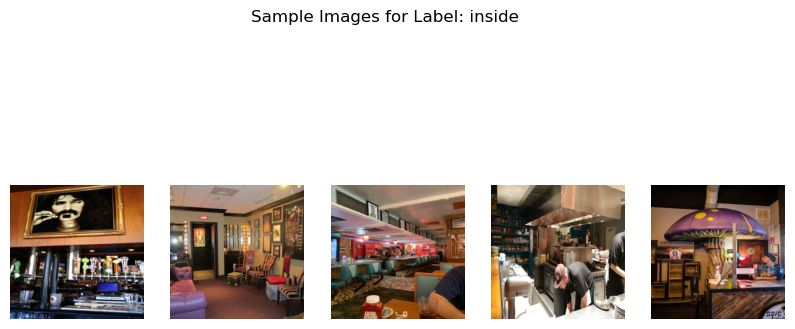

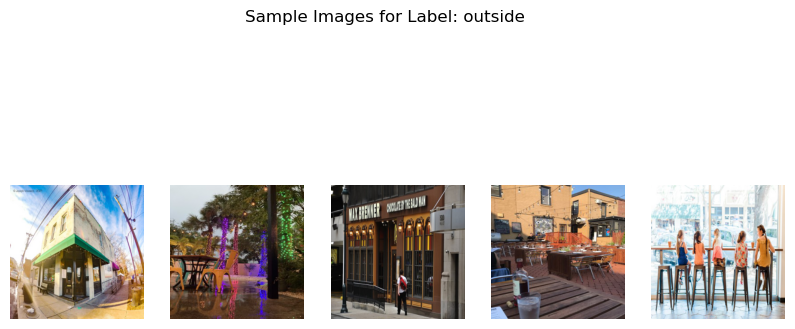

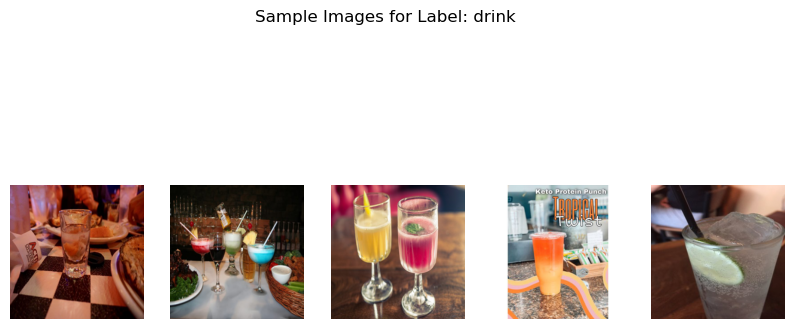

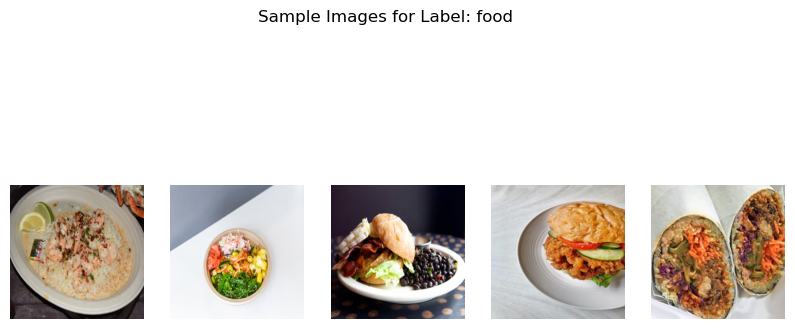

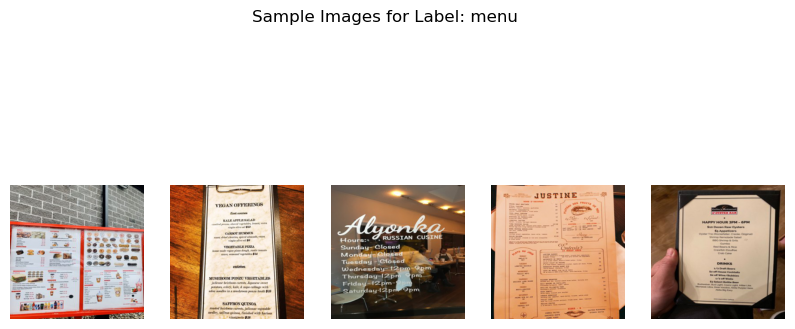

In [3]:
def plot_sample_images(label, num_images=5):
    sample_images = final_df[final_df['label'] == label]['image'].head(num_images)    
    plt.figure(figsize=(10, 5))
    for i, img_array in enumerate(sample_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_array)
        plt.axis('off')
    plt.suptitle(f'Sample Images for Label: {label}')
    plt.show()
# Plot sample images for each label
for label in final_df['label'].unique():
    plot_sample_images(label)


In [4]:
#missing labels
missing_labels = final_df['label'].isnull().sum()
print(f'Missing Labels: {missing_labels}')
#missing images
missing_images = final_df['image'].isnull().sum()
print(f'Missing Images: {missing_images}')


Missing Labels: 0
Missing Images: 0


In [5]:
# Checking if all images have the same shape
image_shapes = [img.shape for img in final_df['image']]
unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")
# Calculating mean and standard deviation of images
image_data = np.array([img.flatten() for img in final_df['image']])
mean_pixel_value = np.mean(image_data)
std_pixel_value = np.std(image_data)
print(f"Mean pixel value: {mean_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")

Unique image shapes: {(224, 224, 3)}
Mean pixel value: 0.4575029893988837
Standard deviation of pixel values: 0.30301191848536047


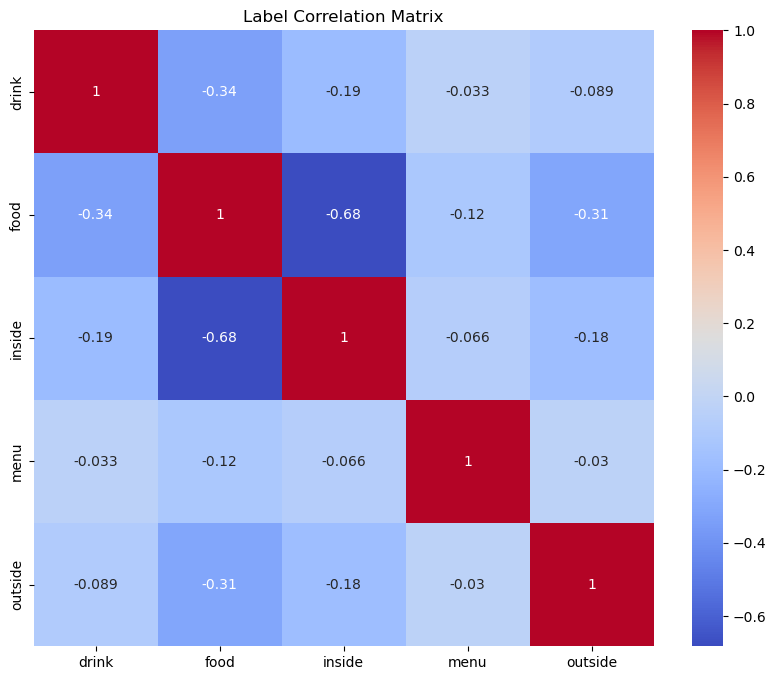

In [6]:
label_mapping_numerical = pd.get_dummies(final_df['label'])
corr_matrix = label_mapping_numerical.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Label Correlation Matrix')
plt.show()


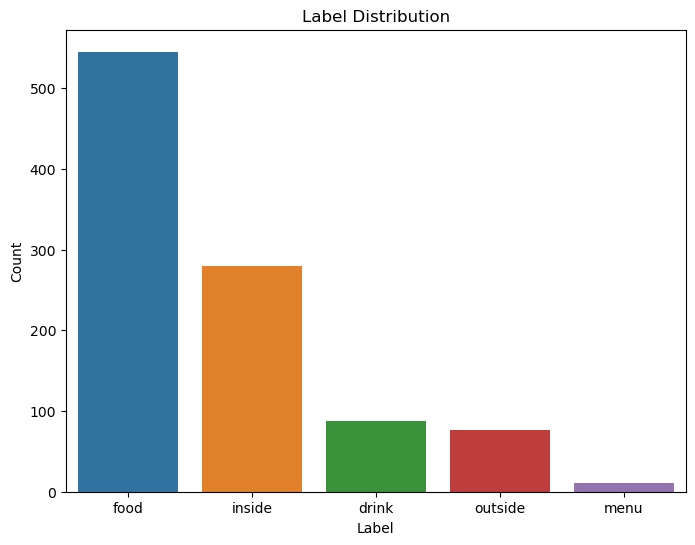

In [7]:
label_distribution = final_df['label'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
final_df['label'].value_counts()

food       545
inside     280
drink       88
outside     76
menu        11
Name: label, dtype: int64

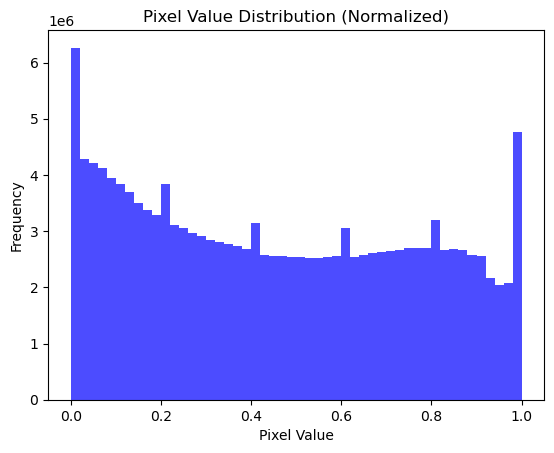

In [9]:
pixel_values = np.concatenate([img.flatten() for img in final_df['image']])
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution (Normalized)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [10]:
final_df['image'].head(5)

0    [[[0.15294117647058825, 0.06666666666666667, 0...
1    [[[0.8313725490196079, 0.8980392156862745, 0.9...
2    [[[0.4980392156862745, 0.28627450980392155, 0....
3    [[[0.12941176470588237, 0.10588235294117647, 0...
4    [[[0.6274509803921569, 0.6627450980392157, 0.7...
Name: image, dtype: object

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight


In [3]:
X = np.array(images)
y = np.array(preprocessed_labels)

In [4]:
encoder = OneHotEncoder(sparse_output=False)#Sparse is false so that tensor can compute it as it only takes dense matrix
y_encoded= encoder.fit_transform(y.reshape(-1, 1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
def create_dnn(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Use softmax for multi-class
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
dnn_model = create_dnn((224, 224, 3))
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
dnn_history = dnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping])


c:\Users\user\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step - accuracy: 0.3120 - loss: 37.3424 - val_accuracy: 0.2850 - val_loss: 1.5901
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.2962 - loss: 1.6071 - val_accuracy: 0.5700 - val_loss: 1.5507
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.4972 - loss: 1.5412 - val_accuracy: 0.5700 - val_loss: 1.5086
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.5058 - loss: 1.9426 - val_accuracy: 0.5700 - val_loss: 1.4710
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.5320 - loss: 1.4754 - val_accuracy: 0.5700 - val_loss: 1.4376
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.5374 - loss: 1.4625 - val_accuracy: 0.5700 - val_loss: 1.4071
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.5453 - loss: 1.4158 - val_accuracy: 0.5700 - val_loss: 1.3794
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5382 - loss: 1.3890 - val_accuracy: 

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
dnn_predictions = dnn_model.predict(X_test)
dnn_fpr, dnn_tpr, _ = roc_curve(y_test.ravel(), dnn_predictions.ravel())
dnn_auc = auc(dnn_fpr, dnn_tpr)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [40]:
def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Use softmax for multi-class
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
# Create and train the CNN
cnn_model = create_cnn((224, 224, 3))
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[EarlyStopping(patience=3)])


c:\Users\user\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 933ms/step - accuracy: 0.4011 - loss: 5.9475 - val_accuracy: 0.7000 - val_loss: 0.9589
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 758ms/step - accuracy: 0.6530 - loss: 0.9892 - val_accuracy: 0.7050 - val_loss: 0.8511
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 752ms/step - accuracy: 0.7315 - loss: 0.7884 - val_accuracy: 0.7200 - val_loss: 0.7773
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.8168 - loss: 0.5585 - val_accuracy: 0.7200 - val_loss: 0.8344
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 741ms/step - accuracy: 0.8688 - loss: 0.3958 - val_accuracy: 0.7300 - val_loss: 0.7822
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 750ms/step - accuracy: 0.9205 - loss: 0.2751 - val_accuracy: 0.7000 - val_loss: 0.8401


In [42]:
cnn_predictions = cnn_model.predict(X_test)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test.ravel(), cnn_predictions.ravel())
cnn_auc = auc(cnn_fpr, cnn_tpr)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step


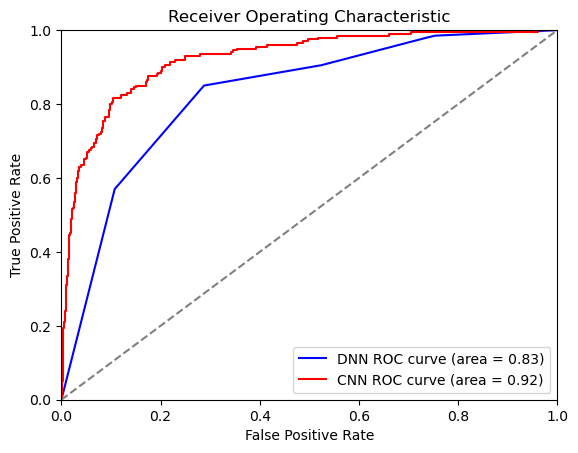

In [43]:
plt.figure()
plt.plot(dnn_fpr, dnn_tpr, color='blue', label='DNN ROC curve (area = {:.2f})'.format(dnn_auc))
plt.plot(cnn_fpr, cnn_tpr, color='red', label='CNN ROC curve (area = {:.2f})'.format(cnn_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


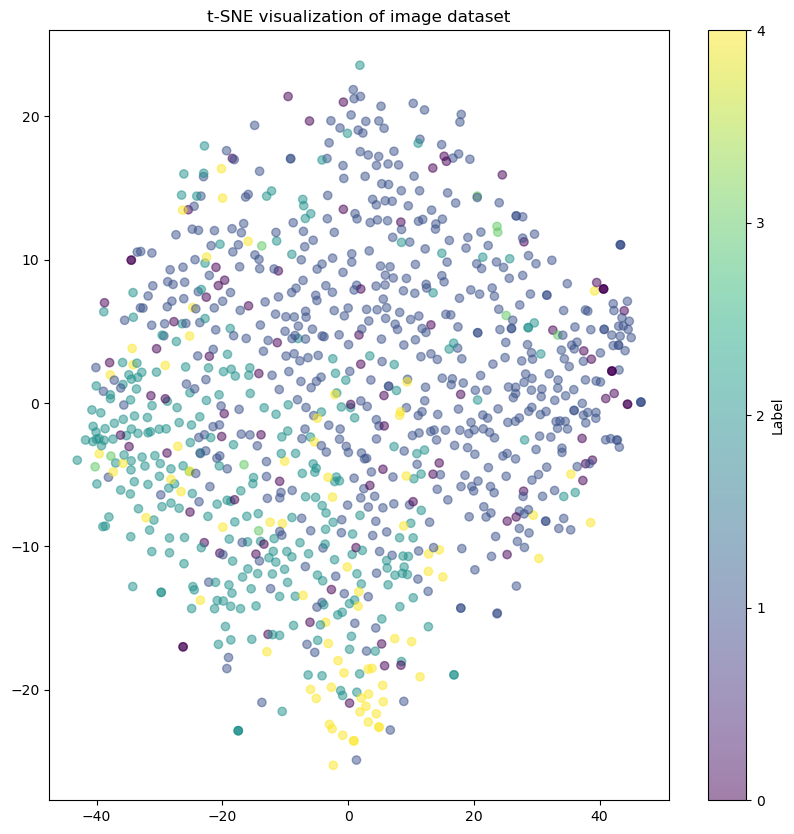

In [21]:
#To check overlapping 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Flattening Images
images = np.array(final_df['image'].tolist())
flattened_images =images.reshape(images.shape[0], -1)
# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(flattened_images)
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=final_df['label'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization of image dataset')
plt.colorbar(ticks=range(len(final_df['label'].unique())), label='Label')
plt.show()

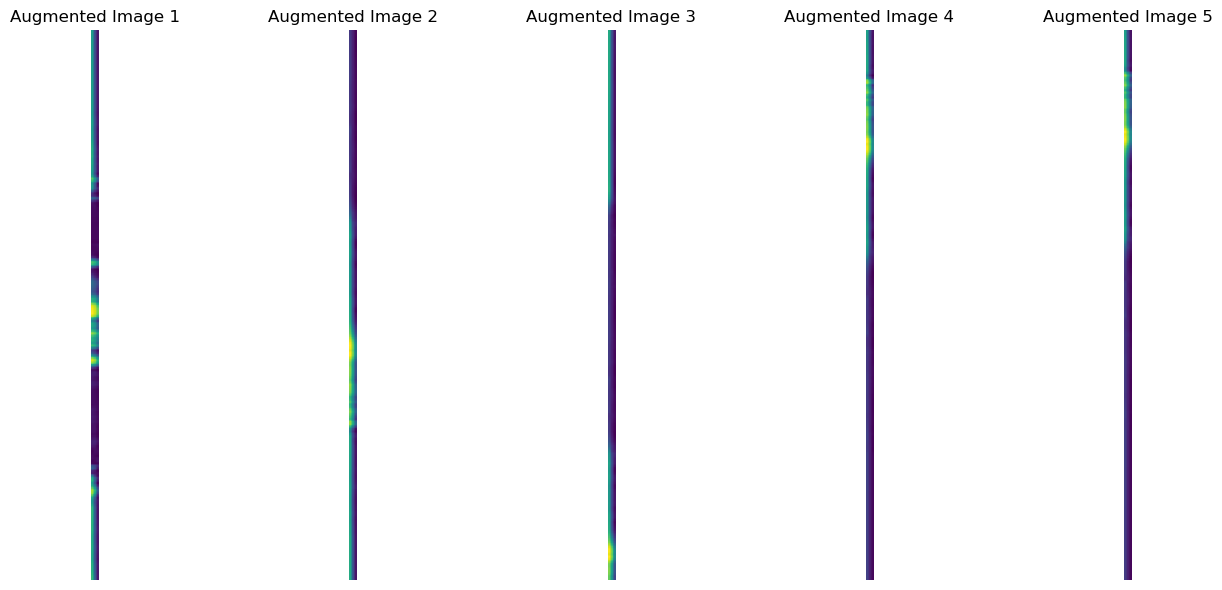

In [23]:
# Step 4: Augmentation Analysis (example with Keras ImageDataGenerator)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
sample_image = np.expand_dims(images[0], axis=0)
augmented_images = datagen.flow(sample_image, batch_size=1)
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = augmented_images[0][0][i]  # Get the ith augmented image
    plt.imshow(img)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
# Define a class that wraps your Keras model
from tensorflow.keras.layers import Flatten
class KerasDNN(BaseEstimator):
    def __init__(self, learning_rate=0.01, neurons=32, epochs=2, batch_size=5):
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    def create_model(self):
        model = Sequential()
        model.add(Dense(self.neurons, input_shape=(224, 224, 3), activation='relu'))
        model.add(Flatten())  
        model.add(Dense(self.neurons, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model
    def fit(self, X, y):
        self.model = self.create_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
    def predict(self, X):
        return self.model.predict(X)
    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy
dnn_model = KerasDNN()
param_grid = {
    'learning_rate': [0.1, 0.01],
    'neurons': [16,32],
    'batch_size': [2,3],
    'epochs': [1,2]
}
random_search = RandomizedSearchCV(estimator=dnn_model, param_distributions=param_grid, n_iter=2, cv=2)
random_search_result = random_search.fit(X_train, y_train)
print("Best DNN Hyperparameters: ", random_search_result.best_params_)

c:\Users\user\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best DNN Hyperparameters:  {'neurons': 16, 'learning_rate': 0.1, 'epochs': 2, 'batch_size': 2}


In [8]:
print("Best Accuracy: ", round(random_search_result.best_score_,2))

Best Accuracy:  0.54


In [9]:
def create_cnn(learning_rate=0.001, filters=32, kernel_size=(3, 3)):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
from sklearn.base import BaseEstimator
class KerasCNN(BaseEstimator):
    def __init__(self, learning_rate=0.001, filters=32, kernel_size=(3, 3), epochs=1, batch_size=2):
        self.learning_rate = learning_rate
        self.filters = filters
        self.kernel_size = kernel_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    def create_model(self):
        return create_cnn(self.learning_rate, self.filters, self.kernel_size)
    def fit(self, X, y):
        self.model = self.create_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
    def predict(self, X):
        return self.model.predict(X)
    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy

In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [14]:
from sklearn.model_selection import RandomizedSearchCV
cnn_model = KerasCNN()
param_grid = {
    'learning_rate': [0.01, 0.001],
    'filters': [16, 32],
    'kernel_size': [(3, 3)],
    'epochs': [1],
    'batch_size': [2]
}
random_search = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid, n_iter=2, cv=2)
random_search_result = random_search.fit(X_train, y_train)
print("Best CNN Hyperparameters: ", random_search_result.best_params_)


c:\Users\user\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best CNN Hyperparameters:  {'learning_rate': 0.001, 'kernel_size': (3, 3), 'filters': 16, 'epochs': 1, 'batch_size': 2}
Best CNN Accuracy: 0.6075000166893005


In [22]:
print("Best CNN Accuracy:",round(random_search_result.best_score_,2))

Best CNN Accuracy: 0.61


The Accuracy reduced to 60% as the epoch was only one and batch size 2,The accuracy can be increased if these two are increased.